In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## 数据准备

In [2]:
df1=pd.read_csv('data/stock_profit.csv')[['code','npMargin','netProfit','MBRevenue','epsTTM','totalShare','liqaShare']]
df2=pd.read_csv('data/stock_growth.csv')[['code','YOYEquity','YOYEPSBasic','YOYNI']]
df3=pd.read_csv('data/stock_balance.csv')[['code','liabilityToAsset','currentRatio','assetToEquity','YOYLiability']]
df4=pd.read_csv('data/stock_dupont.csv')[['code','dupontAssetTurn']]
df5=pd.read_csv('data/stock_industry.csv', encoding='GBK')[['code','code_name','industry']]
df6=pd.read_csv('data/stock_k_data(2024_01_02).csv')[['code','open','volume']]

In [3]:
df=pd.merge(df1,df2,on='code')
df=pd.merge(df,df3,on='code')
df=pd.merge(df,df4,on='code')
df=pd.merge(df,df5,on='code')
df=pd.merge(df,df6,on='code')
df=df[df['industry']=='医药生物']
df=df.dropna().reset_index(drop=True)
print(df.shape,df.columns)
df.head(2)
# df.to_csv('./data/merged.csv')

(393, 19) Index(['code', 'npMargin', 'netProfit', 'MBRevenue', 'epsTTM', 'totalShare',
       'liqaShare', 'YOYEquity', 'YOYEPSBasic', 'YOYNI', 'liabilityToAsset',
       'currentRatio', 'assetToEquity', 'YOYLiability', 'dupontAssetTurn',
       'code_name', 'industry', 'open', 'volume'],
      dtype='object')


,code,npMargin,netProfit,MBRevenue,epsTTM,totalShare,liqaShare,YOYEquity,YOYEPSBasic,YOYNI,liabilityToAsset,currentRatio,assetToEquity,YOYLiability,dupontAssetTurn,code_name,industry,open,volume
0,sh.600055,0.154292,1.908088e+08,1.160940e+09,0.268167,7.030611e+08,5.408162e+08,0.023032,0.000000,0.109107,0.106684,8.379654,1.119424,0.042971,0.232044,万东医疗,医药生物,17.02,8552675.0
1,sh.600056,0.031993,1.242120e+09,3.874528e+10,0.700617,1.495880e+09,1.495351e+09,0.068990,0.424563,0.398110,0.628772,1.584497,2.693759,0.034915,1.059206,中国医药,医药生物,11.17,7867036.0


In [4]:
columns=['npMargin', 'netProfit', 'epsTTM', 'totalShare','liqaShare','YOYEquity','MBRevenue','YOYNI',
       'YOYEPSBasic', 'liabilityToAsset', 'currentRatio', 'assetToEquity',
       'YOYLiability', 'dupontAssetTurn']
X = df[columns]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [5]:
def remove_outliers(series):
    mean = series.mean()
    std = series.std()
    threshold = 3  # 可调整阈值
    return abs(series - mean) <= threshold * std
outliers=X[-X.apply(remove_outliers).all(axis=1)]
X=X[X.apply(remove_outliers).all(axis=1)]

## 因子分析

In [6]:
n_factors = 5  # 指定要提取的因子数量，可以根据需要调整
rotation_method = 'varimax'  # 指定旋转方法，可以根据需要调整
fa = FactorAnalyzer(n_factors, rotation=rotation_method)
fa.fit(X)
loadings = fa.loadings_
fa.get_factor_variance()[2]

array([0.18242512, 0.33342502, 0.47343657, 0.58376383, 0.68317789])

In [7]:
list(fa.loadings_)

[array([-0.18684622,  0.01321794,  0.74099502,  0.12886981, -0.01292685]),
 array([-0.0270876 ,  0.25553545,  0.58324959,  0.04055388,  0.57067964]),
 array([-0.07744862, -0.13042868,  0.85371575,  0.038884  ,  0.2723157 ]),
 array([ 0.13963046,  0.97715237,  0.00242559, -0.0109642 ,  0.15023669]),
 array([ 1.54306107e-01,  9.60338619e-01, -1.43181663e-03, -1.91327216e-04,
         1.53037388e-01]),
 array([ 0.01969826, -0.0148876 ,  0.35274809,  0.13866357,  0.03381659]),
 array([0.28120345, 0.3176798 , 0.15909791, 0.01081546, 0.8921346 ]),
 array([-0.07296837, -0.01936398,  0.09776821,  0.82590085,  0.06464714]),
 array([ 0.02776771,  0.01671565,  0.25149521,  0.89808215, -0.02283638]),
 array([ 0.9953035 ,  0.09823537, -0.13444958, -0.02866241,  0.07712626]),
 array([-0.63188275, -0.12971295,  0.15289002,  0.02648023, -0.10004514]),
 array([ 0.88711742,  0.08723045, -0.10442376, -0.05852634,  0.08501301]),
 array([ 0.1522608 , -0.13418442,  0.08955564, -0.00095525, -0.05423313]),
 a

In [8]:
columns

['npMargin',
 'netProfit',
 'epsTTM',
 'totalShare',
 'liqaShare',
 'YOYEquity',
 'MBRevenue',
 'YOYNI',
 'YOYEPSBasic',
 'liabilityToAsset',
 'currentRatio',
 'assetToEquity',
 'YOYLiability',
 'dupontAssetTurn']

In [9]:
factor_scores=fa.transform(X)
X_1=pd.DataFrame(data=factor_scores, columns=[f'Factor{i+1}' for i in range(n_factors)])
X_1

,Factor1,Factor2,Factor3,Factor4,Factor5
0,-1.317316,0.273065,-0.166053,0.063610,-0.275201
1,1.239260,0.156290,-1.200021,0.495685,6.999411
2,-0.604659,0.522489,0.652305,0.005606,1.182476
3,0.617931,0.986466,0.708863,-0.175834,3.390242
4,-0.881921,-0.374919,-0.898292,-0.931654,0.001615
...,...,...,...,...,...
337,-1.035892,-0.690937,0.725058,-0.250922,-0.252751
338,-0.507185,-0.764331,0.363965,-0.080602,0.295810
339,-1.026594,-0.809878,1.223899,-0.256035,-0.012367
340,-1.125470,-0.656118,0.293144,0.099415,-0.187067


## Kmeans 聚类

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Text(0.5, 1.0, 'Silhouette score vs Number of clusters')

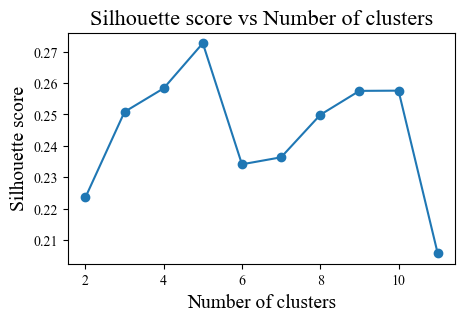

In [11]:
silhouette_avg = []
for i in tqdm(range(10)):
    kmeans = KMeans(n_clusters=i+2,n_init=100)
    kmeans.fit(X_1)
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X_1, labels))

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(5,3))
plt.plot(range(2,12),silhouette_avg,marker='o')
plt.xlabel('Number of clusters',fontsize=14)
plt.ylabel('Silhouette score',fontsize=14)
plt.title('Silhouette score vs Number of clusters', fontsize=16)

In [38]:
kmeans = KMeans(n_clusters=5, n_init=300, random_state=42)
kmeans.fit(X_1)
labels = kmeans.labels_
silhouette_score(X_1, labels)

0.2724078007632001

In [39]:
kmeans.cluster_centers_

array([[ 0.36612993,  0.03376907, -0.84725955, -4.8657474 , -0.46974534],
       [-0.79560639, -0.17024949,  0.11907546,  0.00999713, -0.02161056],
       [ 0.23104701,  2.61499508,  0.03742687,  0.03290905, -0.26723003],
       [ 0.97609895, -0.33265091, -0.16942444,  0.21520642, -0.2985108 ],
       [ 0.9139122 ,  0.20976964,  0.3426216 ,  0.00991346,  4.18876086]])

d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fu

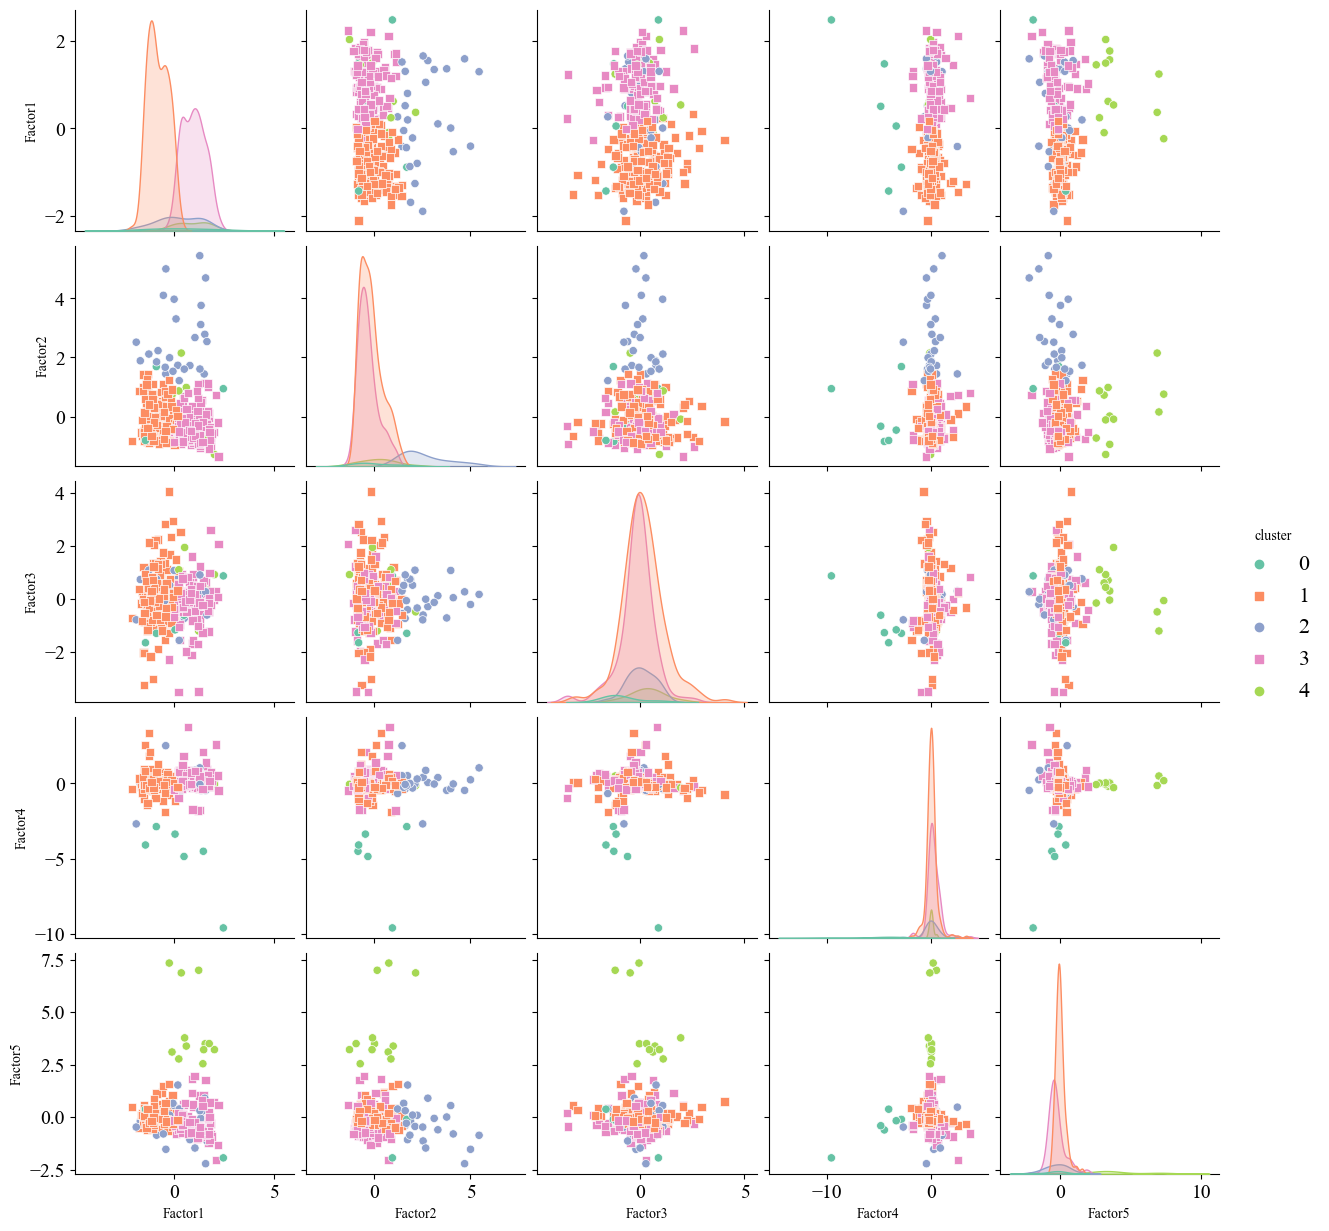

In [40]:
X_vis=X_1.copy()
X_vis['cluster']=labels




# 现在调用sns.pairplot
sns.pairplot(X_vis, diag_kind='kde', hue='cluster', palette='Set2', diag_kws=dict(shade=True), markers=['o', 's'])
# 设置字体大小
# plt.title('Pairplot of the K-means clusters', fontsize=20)
plt.rc('axes', labelsize=25)    # 设置坐标轴标签的字体大小
plt.rc('xtick', labelsize=14)   # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=14)   # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=16)   # 设置图例的字体大小
plt.show()


In [15]:
pd.Series(labels).value_counts()

0    177
3    122
1     31
2     12
dtype: int64

In [16]:
df_merged=pd.merge(df, X_vis, left_index=True, right_index=True,how='inner')
df_merged.reset_index(drop=True,inplace=True)
df_merged.head(2)

,code,npMargin,netProfit,MBRevenue,epsTTM,totalShare,liqaShare,YOYEquity,YOYEPSBasic,YOYNI,...,code_name,industry,open,volume,Factor1,Factor2,Factor3,Factor4,Factor5,cluster
0,sh.600055,0.154292,1.908088e+08,1.160940e+09,0.268167,7.030611e+08,5.408162e+08,0.023032,0.000000,0.109107,...,万东医疗,医药生物,17.02,8552675.0,-1.317316,0.273065,-0.166053,0.063610,-0.275201,0
1,sh.600056,0.031993,1.242120e+09,3.874528e+10,0.700617,1.495880e+09,1.495351e+09,0.068990,0.424563,0.398110,...,中国医药,医药生物,11.17,7867036.0,1.239260,0.156290,-1.200021,0.495685,6.999411,2


## 多元线性回归

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假设df_merged是一个包含回归特征和目标变量的DataFrame
X = df_merged[columns]
y = df_merged['open']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并拟合岭回归模型
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# 进行预测
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# 评估模型
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


Train MSE: 641.6736368342304
Test MSE: 625.3887097716673


d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.14152e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [18]:
from sklearn.linear_model import RidgeCV

# 使用交叉验证选择最佳alpha
alphas = [0.1, 1.0, 10.0, 100.0,200,300,400,500]
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# 输出最佳alpha
print(f'Best alpha: {ridge_cv.alpha_}')
y_pred_cv = ridge_cv.predict(X_test)
test_mse_cv = mean_squared_error(y_test, y_pred_cv)
print(f'Test MSE with RidgeCV: {test_mse_cv}')
# y_pred = ridge_cv.predict(X)


Best alpha: 300.0
Test MSE with RidgeCV: 780.3329453843971


d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.6208e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.8187e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.68717e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.83655e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211:

In [19]:
from sklearn.linear_model import Ridge

X = df_merged[columns]
y = df_merged['open']
ridge = Ridge(alpha=300.0)
ridge.fit(X, y)
y_pred = ridge.predict(X)

d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.07809e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


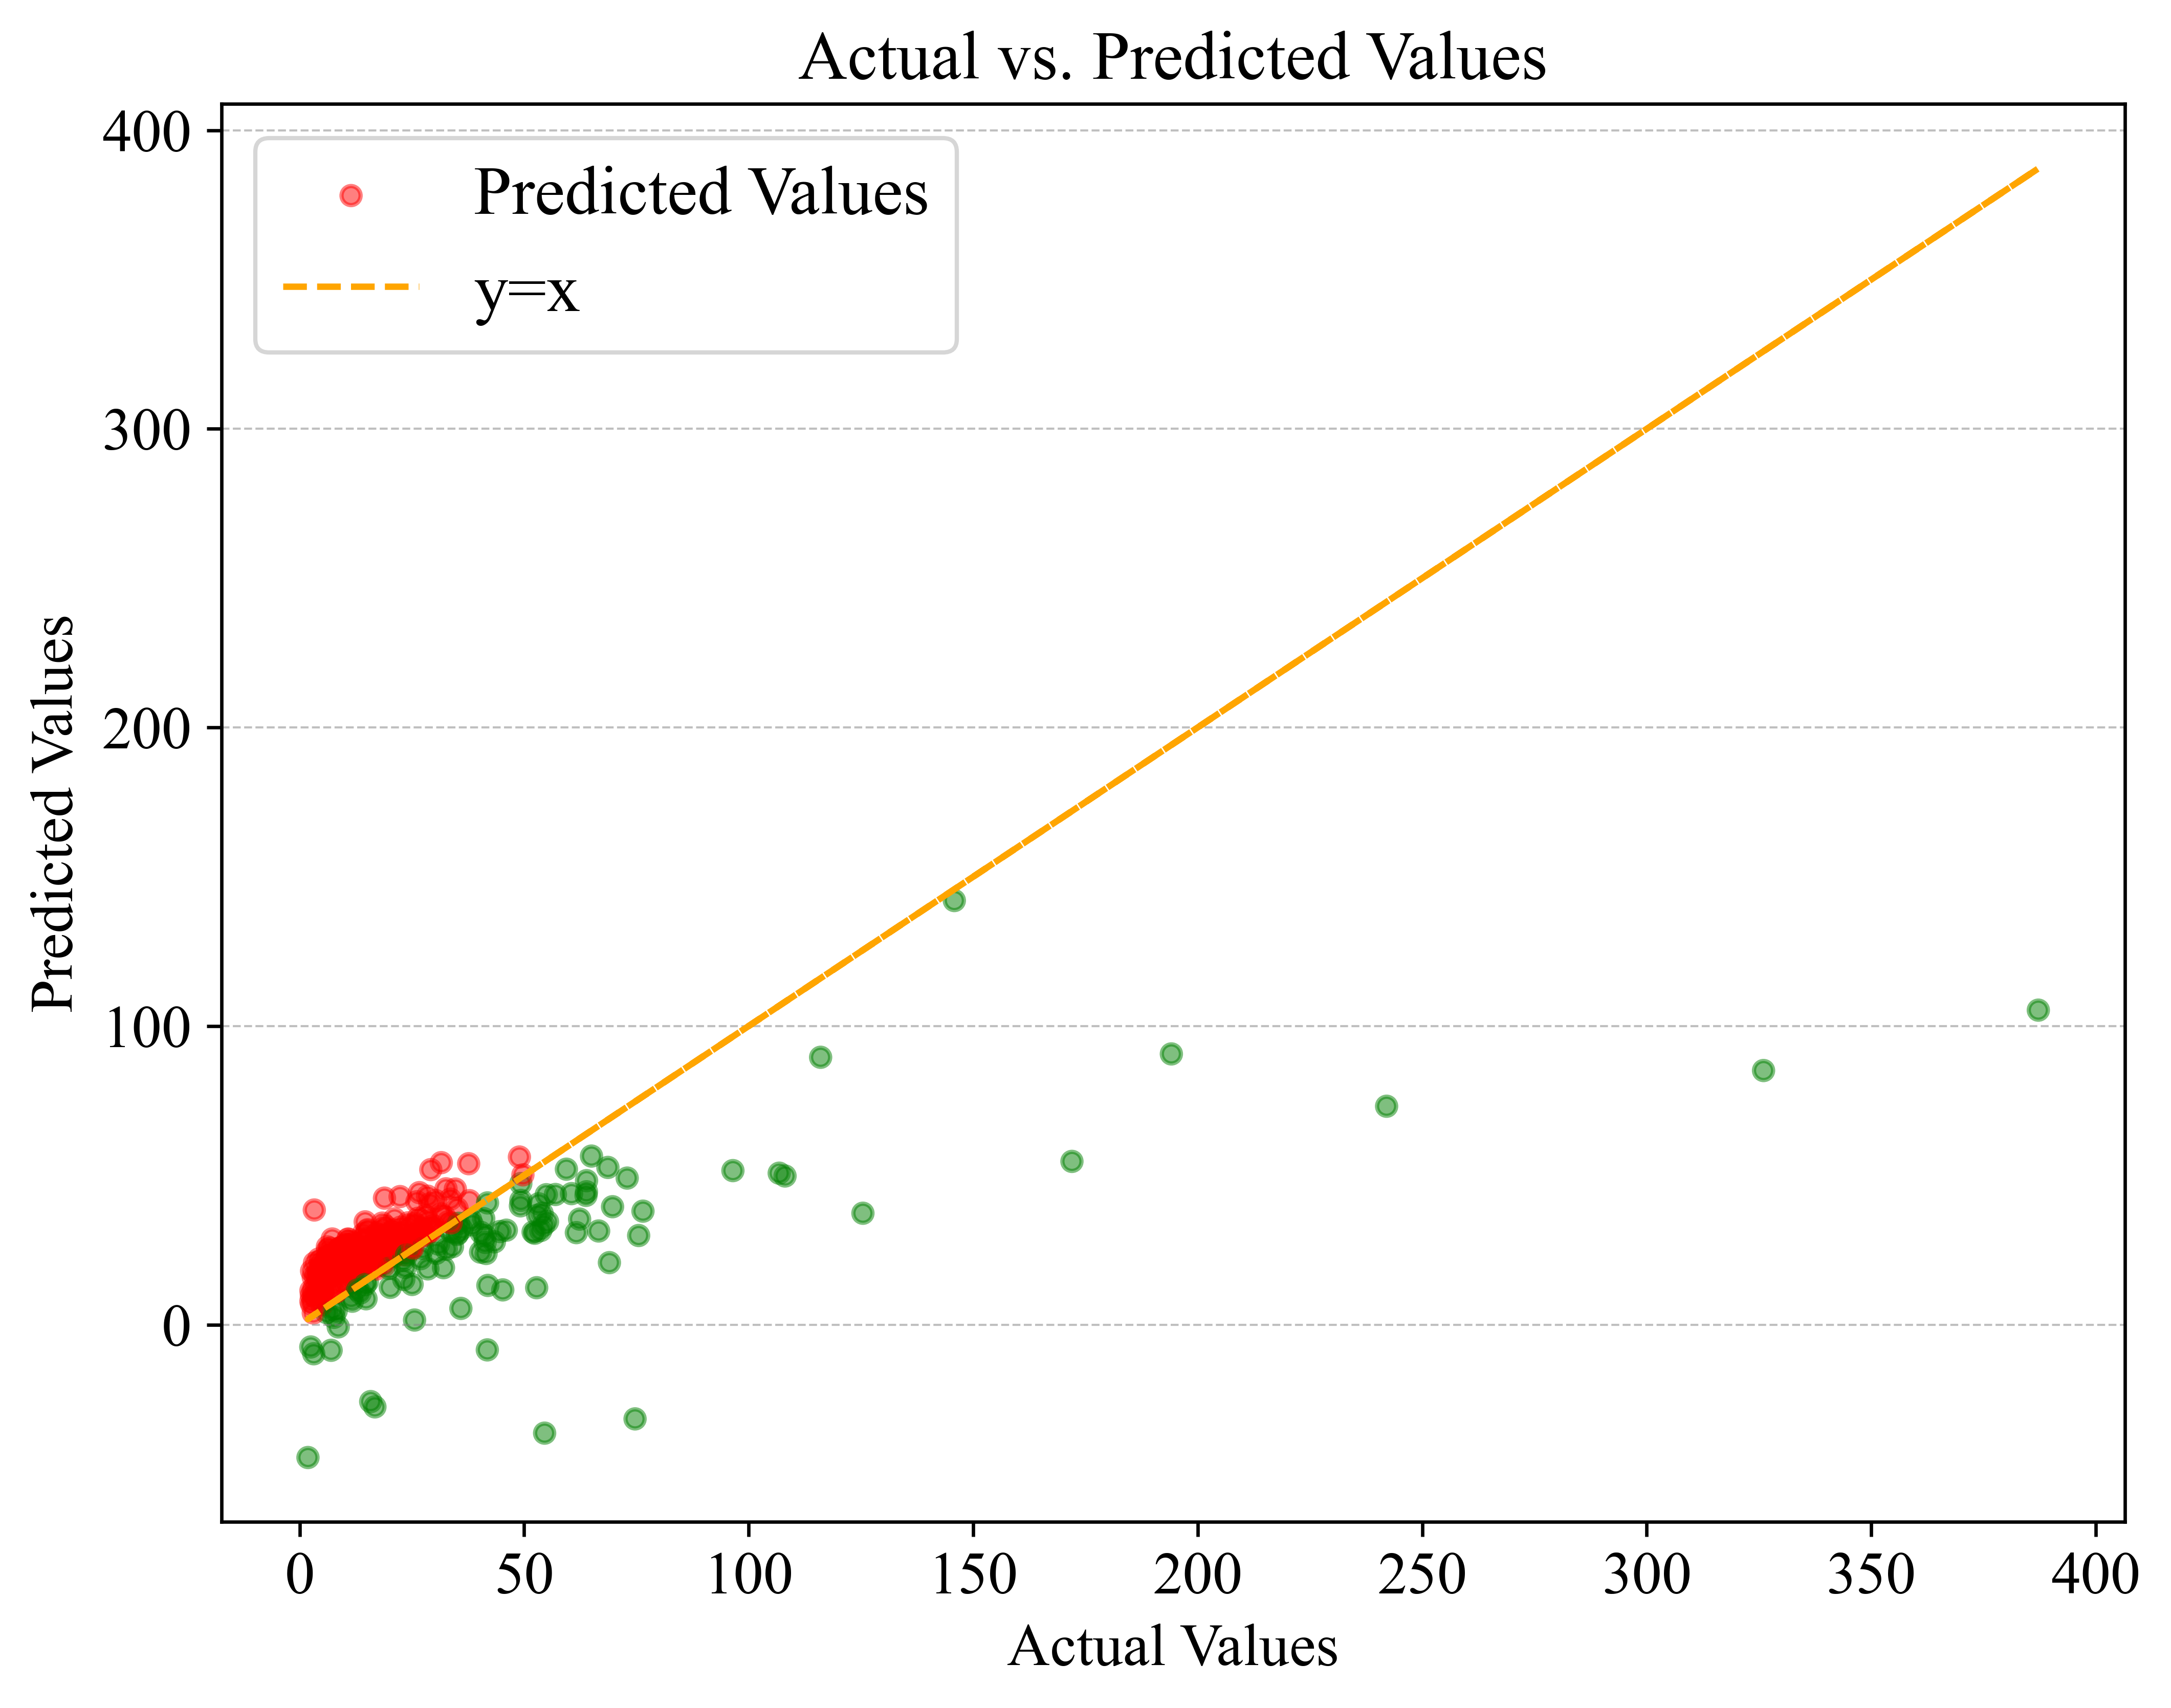

In [37]:
y_pred = ridge_cv.predict(X)
plt.figure(figsize=(8,6),dpi=600)
plt.scatter(df_merged['open'], y_pred, label='Predicted Values', s=20, alpha=0.5, color=['red' if y_pred[i] > df_merged['open'][i] else 'green' for i in range(len(y_pred))])
plt.plot(df_merged['open'], df_merged['open'], color='orange', linestyle='--', label='y=x')
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted Values', fontsize=16)
plt.legend()
plt.show()


## 定义潜力股:  
1. 股票的预测价格高于实际价格 
2. 股票的收益整体是正的  
排名：股票收益率* residual

In [77]:

df_merged['predicted_open']=y_pred

df_merged['residual']=df_merged['predicted_open']-df_merged['open']
stock_candidate=df_merged[(df_merged['residual']>0)&(df_merged['epsTTM']>0)]
stock_candidate['ranking']=stock_candidate['residual']*stock_candidate['epsTTM']
stock_candidate=stock_candidate.sort_values(by='ranking',ascending=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30576\2385448088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_candidate['ranking']=stock_candidate['residual']*stock_candidate['epsTTM']


In [78]:
stock_candidate['code_name']

200    长春高新
37     济川药业
209    华特达因
78     柳药集团
250    九安医疗
       ... 
260    瑞康医药
84      美诺华
324    博雅生物
55     华北制药
231     新里程
Name: code_name, Length: 197, dtype: object

## Compare the result to the tempory stock data

In [79]:
df_ref=pd.read_csv('data/stock_k_data(2024_04_01).csv')[['code','open']]
df_ref=pd.merge(df_merged[['code','open','code_name']],df_ref,on='code',how='inner')
print(df_ref.shape,df_ref.columns)
df_ref.head(10)

(342, 4) Index(['code', 'open_x', 'code_name', 'open_y'], dtype='object')


,code,open_x,code_name,open_y
0,sh.600055,17.02,万东医疗,14.62
1,sh.600056,11.17,中国医药,11.00
2,sh.600062,18.65,华润双鹤,20.65
3,sh.600079,24.88,人福医药,19.40
4,sh.600080,7.48,金花股份,7.02
5,sh.600085,53.70,同仁堂,41.02
6,sh.600129,46.03,太极集团,33.30
7,sh.600161,30.94,天坛生物,27.02
8,sh.600196,25.05,复星医药,23.00
9,sh.600200,8.25,江苏吴中,11.44


In [80]:
mean=(df_ref['open_y']-df_ref['open_x']).mean()
mean

-3.366812865497076

In [87]:
top_df=df_ref[df_ref['code'].isin(stock_candidate['code'][:10])]
(top_df['open_y']-top_df['open_x']).mean()

-0.3820000000000011

In [88]:
top_df

,code,open_x,code_name,open_y
10,sh.600211,48.95,西藏药业,44.13
28,sh.600511,28.50,国药股份,33.00
37,sh.600566,31.55,济川药业,37.43
78,sh.603368,18.90,柳药集团,21.20
181,sz.000028,29.02,国药一致,30.74
200,sz.000661,145.80,长春高新,120.43
209,sz.000915,29.21,华特达因,35.41
245,sz.002393,26.66,力生制药,24.80
250,sz.002432,37.65,九安医疗,44.05
269,sz.002737,26.12,葵花药业,27.35
